# Stanford CME 241 (Winter 2024) - Assignment 5

**Due: Feb 12 @ 11:59pm Pacific Time on Gradescope.**

Assignment instructions:
- **Solve any 3 of the 4 questions.**
- Empty code blocks are for your use. Feel free to create more under each section as needed.

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):* 

https://github.com/sanj909/cme241/blob/master/assignments/assignment5.ipynb

*Group members (replace below names with people in your group):* 
- Sanjit Neelam
- Ryan Padnis

## Imports

In [1]:
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import poisson, normal
from typing import Sequence

from rl.chapter9.order_book import OrderBook, DollarsAndShares
from rl.distribution import Bernoulli, Constant, Distribution, SampledDistribution
from rl.markov_process import MarkovProcess, State, NonTerminal

## Question 1
You are a milkvendor and your task is to bring to your store a supply
(denoted $S \in \mathbb{R}$) of milk volume in the morning that will
give you the best profits. You know that the demand for milk through the
course of the day is a probability distribution function $f$ (for
mathematical convenience, assume people can buy milk in volumes that are
real numbers, hence milk demand $x \in \mathbb{R}$ is a continuous
variable with a probability density function). For every extra gallon of
milk you carry at the end of the day (supply $S$ exceeds random demand
$x$), you incur a cost of $h$ (effectively the wasteful purchases
amounting to the difference between your purchase price and end-of-day
discount disposal price since you are not allowed to sell the same milk
the next day). For every gallon of milk that a customer demands that you
don't carry (random demand $x$ exceeds supply $S$), you incur a cost of
$p$ (effectively the missed sales revenue amounting to the difference
between your sales price and purchase price). So your task is to
identify the optimal supply $S$ that minimizes your Expected Cost
$g(S)$, given by the following:

$$g_1(S) = E[\max(x-S, 0)] = \int_{-\infty}^{\infty} \max(x-S, 0) \cdot f(x) \cdot dx = \int_S^{\infty} (x-S) \cdot f(x) \cdot dx$$
$$g_2(S) = E[\max(S-x, 0)] = \int_{-\infty}^{\infty} \max(S-x, 0) \cdot f(x) \cdot dx = \int_{-\infty}^S (S-x) \cdot f(x) \cdot dx$$

$$g(S) = p \cdot g_1(S) + h \cdot g_2(S)$$

After you solve this problem, see if you can frame this problem in terms
of a call/put options portfolio problem.

## Question 2
[rl/chapter8/optimal_bin_tree.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter8/optimal_exercise_bin_tree.py)
models the American Payoff pricing problem as a `FiniteMarkovDecisionProcess` in the form of a binary tree with only two
discrete transitions for any given asset price. In the world of mathematical and computational finance, it is common practice to work
with continuous-valued asset prices and transitions to a continuous set of asset prices for the next time step. Your task is to model this
problem as a `MarkovDecisionProcess` (not finite) with discrete time, continuous-valued asset prices and a continuous-set of transitions.
Assume an arbitrary probability distribution for asset price movements from one time step to another, so you'd be sampling from the arbitrary
transition probability distribution. Hence, you will be solving this problem with Approximate Dynamic Programming using the code in
[rl/approximate_dynamic_programming.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/approximate_dynamic_programming.py).

## Question 3
We'd like to build a simple simulator of Order Book Dynamics as a
`MarkovProcess` using the code in
[rl/chapter9/order_book.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter9/order_book.py).
An object of type `OrderBook` constitutes the *State*. Your task is to
come up with a simple model for random arrivals of Market Orders and
Limit Orders based on the current contents of the `OrderBook`. This
model of random arrivals of Market Orders and Limit Orders defines the
probabilistic transitions from the current state (`OrderBook` object) to
the next state (`OrderBook` object). Implement the probabilistic
transitions as a `MarkovProcess` and use it's `simulate` method to
complete your implementation of a simple simulator of Order Book
Dynamics.

Experiment with different models for random arrivals of Market Orders
and Limit Orders.

- We experiment with two different models for random arrivals of Market Orders and Limit Orders.

In [2]:
class DynamicOrderBook(MarkovProcess[OrderBook]):
    p_limit: float
    p_buy: float

    def __init__(self, p_limit: float, p_buy: float, transition_model: int):
        self.p_limit = p_limit
        self.p_buy = p_buy
        self.transition_model = transition_model

    def transition_1(self, state: NonTerminal[OrderBook]) \
        -> Distribution[State[OrderBook]]:
        def next_state(state=state):
            next_is_limit: bool = Bernoulli(self.p_limit).sample()
            next_is_buy: bool = Bernoulli(self.p_buy).sample()
            
            all_prices: np.ndarray = np.concatenate((
                [x.dollars for x in state.state.descending_bids],
                [x.dollars for x in state.state.ascending_asks]
            ))
            all_quantities: np.ndarray = np.concatenate((
                [x.shares for x in state.state.descending_bids],
                [x.shares for x in state.state.ascending_asks]
            ))

            if next_is_limit and next_is_buy:
                next_st: OrderBook = state.state.buy_limit_order(
                    np.mean(all_prices), 
                    np.mean(all_quantities)
                )[1]
            elif next_is_limit and not next_is_buy:
                next_st: OrderBook = state.state.sell_limit_order(
                    np.mean(all_prices), 
                    np.mean(all_quantities)
                )[1]
            elif not next_is_limit and next_is_buy:
                next_st: OrderBook = state.state.buy_market_order(
                    np.mean(all_quantities)
                )[1]
            elif not next_is_limit and not next_is_buy:
                next_st: OrderBook = state.state.sell_market_order(
                    np.mean(all_quantities)
                )[1]
            
            return NonTerminal(next_st)

        return SampledDistribution(next_state)
    
    def transition_2(self, state: NonTerminal[OrderBook]) \
        -> Distribution[State[OrderBook]]:
        def next_state(state=state):
            next_is_limit: bool = Bernoulli(self.p_limit).sample()
            next_is_buy: bool = Bernoulli(self.p_buy).sample()

            bids = [x.dollars for x in state.state.descending_bids]
            asks = [x.dollars for x in state.state.ascending_asks]
            bids_iqr = np.percentile(bids, 75) - np.percentile(bids, 25)
            asks_iqr = np.percentile(asks, 75) - np.percentile(asks, 25)
            if max(bids) > np.percentile(bids, 75) + 1.5 * bids_iqr:
                next_is_limit = False
                next_is_buy = False
            elif min(asks) < np.percentile(asks, 25) - 1.5 * asks_iqr:
                next_is_limit = False
                next_is_buy = True
            
            bid_qs = [x.shares for x in state.state.descending_bids]
            ask_qs = [x.shares for x in state.state.ascending_asks]

            if next_is_limit and next_is_buy:
                next_st: OrderBook = state.state.buy_limit_order(
                    np.max(bids) + normal(0, 1),
                    poisson(np.mean(bid_qs))
                )[1]
            elif next_is_limit and not next_is_buy:
                next_st: OrderBook = state.state.sell_limit_order(
                    np.min(asks) - normal(0, 1),
                    poisson(np.mean(ask_qs))
                )[1]
            elif not next_is_limit and next_is_buy:
                next_st: OrderBook = state.state.buy_market_order(
                    0.5 * poisson(np.mean(bid_qs))
                )[1]
            elif not next_is_limit and not next_is_buy:
                next_st: OrderBook = state.state.sell_market_order(
                    0.5 * poisson(np.mean(ask_qs))
                )[1]
            
            return NonTerminal(next_st)

        return SampledDistribution(next_state)
    
    def transition(self, state: NonTerminal[OrderBook]) \
        -> Distribution[State[OrderBook]]:
        if self.transition_model == 1:
            return self.transition_1(state)
        elif self.transition_model == 2:
            return self.transition_2(state)

- In the first model, we assume that
    - The next order is a market order with probability `p_limit` and is a buy order with probabiity `p_buy`,
    - The price of the next limit order is the mean of the prices of all limit orders in the order book, and
    - The quantity of the next order is the mean of the prices of all limit orders in the order book.
- This is not a realistic model since e.g.
    - We can see that some buy limit orders are at a much higher price than the previous bid price and some sell limit orders are at a much lower price than the previous ask price.
    - We would ordinarily expect such limit orders to be taken advantage of immediately, but this does not happen in our model since e.g. it assumes the type of the next order is independent of the current state of the order book.
    - The bid_ask_spread appears to increase over time.
    - The quantity of the next order is determined in the same way for both limit and market orders. Intuitively, we might expect that the quantity in a limit order is on average higher than the quantit in a market order since the former is placed by a trader who is willing to wait for a good price.

Iteration 0
Bid-ask spread: 5
Market depth: 23


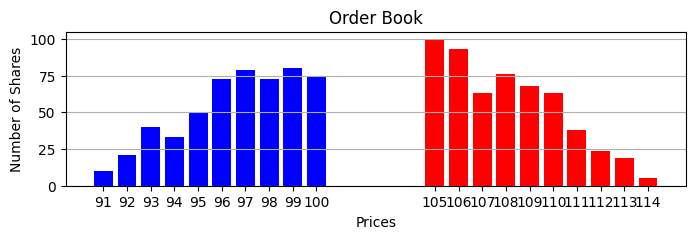

--------------------------------------------------------------------------------
Iteration 5
Bid-ask spread: 3.6315789473684106
Market depth: 23


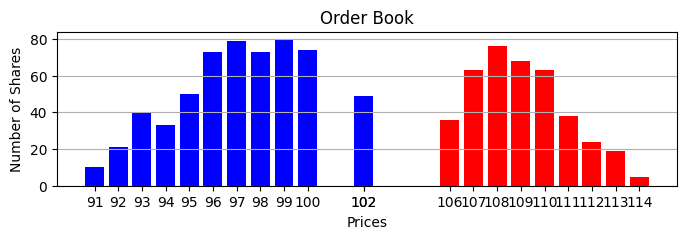

--------------------------------------------------------------------------------
Iteration 10
Bid-ask spread: 4.631578947368411
Market depth: 23


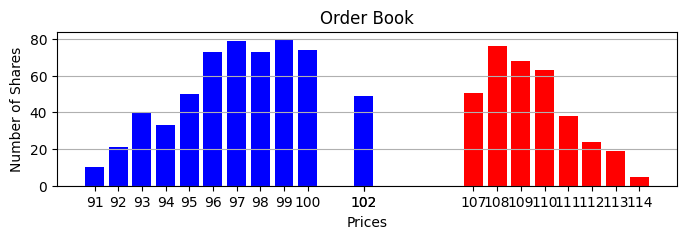

--------------------------------------------------------------------------------
Iteration 15
Bid-ask spread: 2.1666666666666714
Market depth: 23


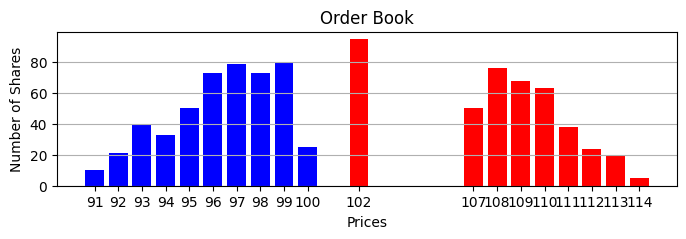

--------------------------------------------------------------------------------
Iteration 20
Bid-ask spread: 9
Market depth: 23


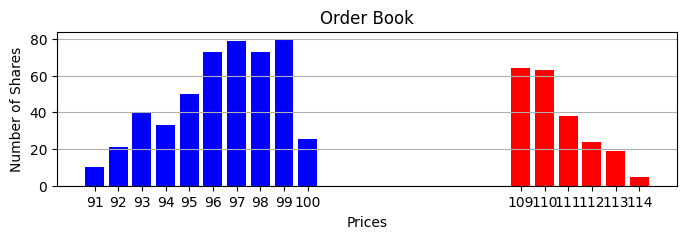

--------------------------------------------------------------------------------
Iteration 25
Bid-ask spread: 7.5
Market depth: 23


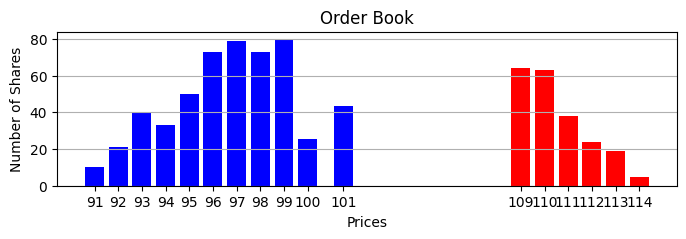

--------------------------------------------------------------------------------
Iteration 30
Bid-ask spread: 2.5
Market depth: 23


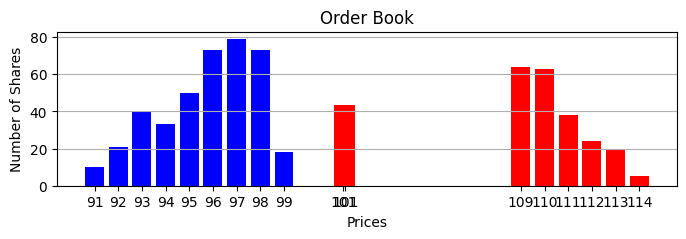

--------------------------------------------------------------------------------
Iteration 35
Bid-ask spread: 11
Market depth: 23


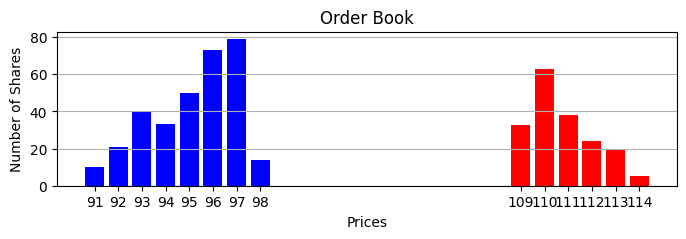

--------------------------------------------------------------------------------
Iteration 40
Bid-ask spread: 8.5
Market depth: 23


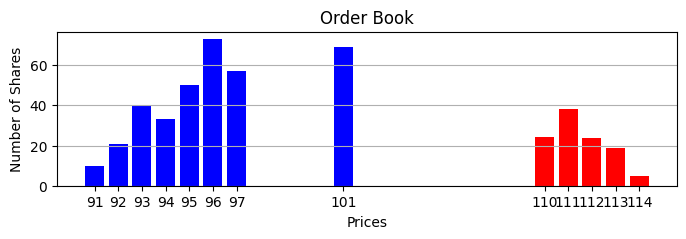

--------------------------------------------------------------------------------
Iteration 45
Bid-ask spread: 10.5
Market depth: 23


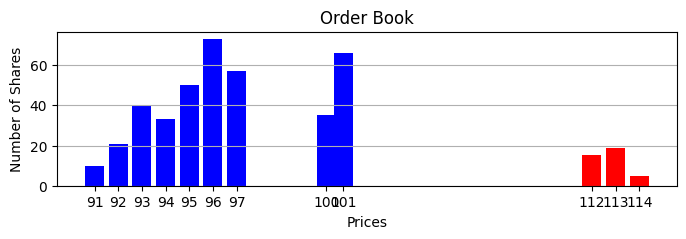

--------------------------------------------------------------------------------


In [4]:
order_book_mp: DynamicOrderBook = DynamicOrderBook(
    p_limit=0.5, 
    p_buy=0.5,
    transition_model=1
)

ob_0 = OrderBook(
    descending_bids=[DollarsAndShares(
        dollars=x,
        shares=poisson(100. - (100 - x) * 10)
    ) for x in range(100, 90, -1)], 
    ascending_asks=[DollarsAndShares(
        dollars=x,
        shares=poisson(100. - (x - 105) * 10)
    ) for x in range(105, 115, 1)]
)
init_ob_dist: Distribution[NonTerminal[OrderBook]] = Constant(NonTerminal(ob_0))
dynamic_order_book = order_book_mp.simulate(init_ob_dist)

MAX_ITER = 50
PRINT_INTERVAL = 5
for i in range(MAX_ITER):
    cur_ob = next(dynamic_order_book).state
    if i % PRINT_INTERVAL == 0:
        print(f'Iteration {i}')
        print(f'Bid-ask spread: {cur_ob.bid_ask_spread()}')
        print(f'Market depth: {cur_ob.market_depth()}')
        plt.figure(figsize=(8, 2))
        cur_ob.display_order_book()
        print('-' * 80)

- In the second model, we assume that
    - The next order is a market order with probability `p_limit` and is a buy order with probabiity `p_buy`, unless
        -  the best bid is an outlier (greater than 1.5 times the inter-quartile range above the third quartile), in which case the next order is a sell market order.
        - the best ask is an outlier (less than 1.5 times the inter-quartile range below the first quartile), in which case the next order is a buy market order.
    - The price of the next buy (sell) limit order is normally distributed, where the mean of the normal distribution is the max of the prices of all buy (sell) limit orders in the order book and the variance of the normal distribution is 1.
    - The quantity of the next limit order is poisson distributed, where the mean of the poisson distribution is the mean of the quantities of all limit orders in the order book.
    - The quantities of the next market order is half what the quantity of the next limit order would be.
- This model appears more realistic than the first model, since e.g.
    - We no longer observe outlier bid and ask prices.
    - The bid-ask spread no longer increases over time.

Iteration 0
Bid-ask spread: 5
Market depth: 23


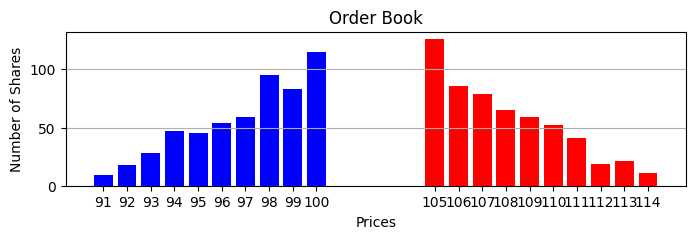

--------------------------------------------------------------------------------
Iteration 5
Bid-ask spread: 4.587804424370688
Market depth: 23


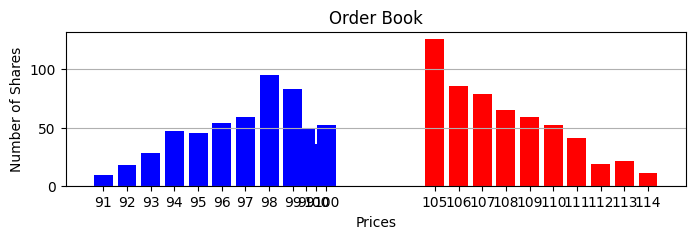

--------------------------------------------------------------------------------
Iteration 10
Bid-ask spread: 4.538213042456391
Market depth: 23


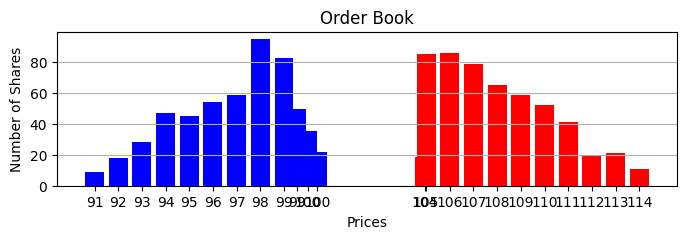

--------------------------------------------------------------------------------
Iteration 15
Bid-ask spread: 4.340518129143533
Market depth: 23


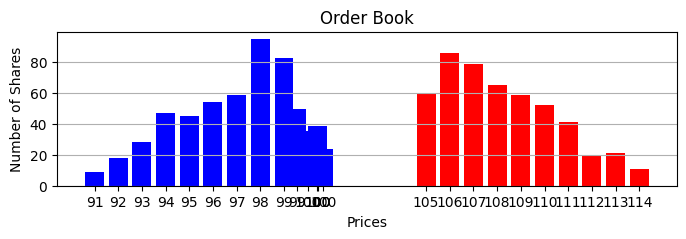

--------------------------------------------------------------------------------
Iteration 20
Bid-ask spread: 3.4025559975021054
Market depth: 23


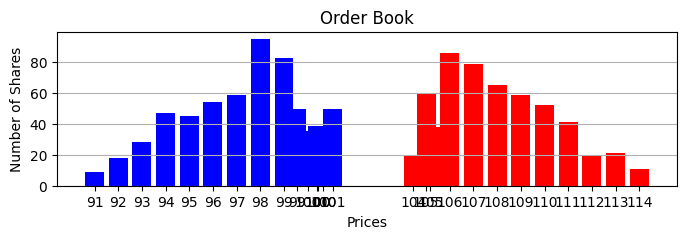

--------------------------------------------------------------------------------
Iteration 25
Bid-ask spread: 3.9383087266267296
Market depth: 23


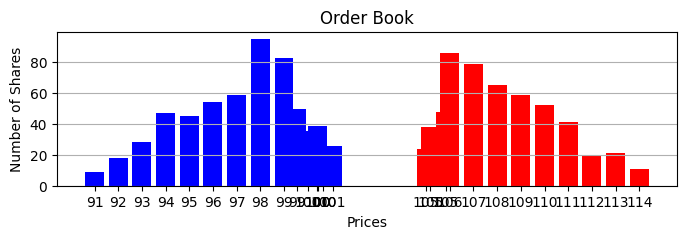

--------------------------------------------------------------------------------
Iteration 30
Bid-ask spread: 3.1750658428502447
Market depth: 23


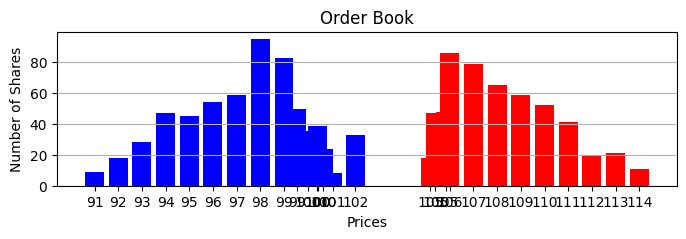

--------------------------------------------------------------------------------
Iteration 35
Bid-ask spread: 1.8887366508289318
Market depth: 23


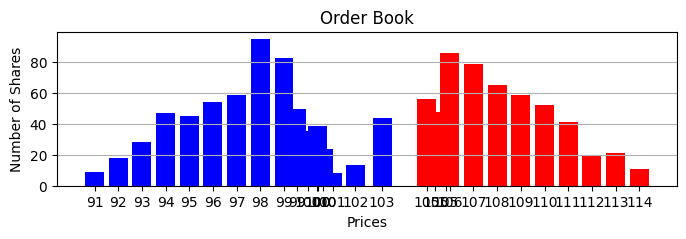

--------------------------------------------------------------------------------
Iteration 40
Bid-ask spread: 1.8887366508289318
Market depth: 23


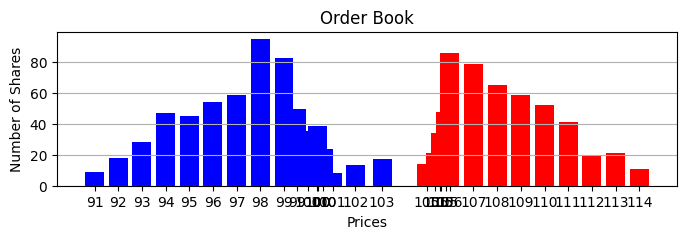

--------------------------------------------------------------------------------
Iteration 45
Bid-ask spread: 4.2535097887516
Market depth: 23


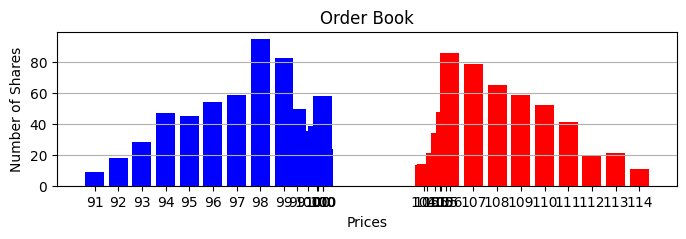

--------------------------------------------------------------------------------


In [5]:
order_book_mp: DynamicOrderBook = DynamicOrderBook(
    p_limit=0.5, 
    p_buy=0.5,
    transition_model=2
)

ob_0 = OrderBook(
    descending_bids=[DollarsAndShares(
        dollars=x,
        shares=poisson(100. - (100 - x) * 10)
    ) for x in range(100, 90, -1)], 
    ascending_asks=[DollarsAndShares(
        dollars=x,
        shares=poisson(100. - (x - 105) * 10)
    ) for x in range(105, 115, 1)]
)
init_ob_dist: Distribution[NonTerminal[OrderBook]] = Constant(NonTerminal(ob_0))
dynamic_order_book = order_book_mp.simulate(init_ob_dist)

MAX_ITER = 50
PRINT_INTERVAL = 5
for i in range(MAX_ITER):
    cur_ob = next(dynamic_order_book).state
    if i % PRINT_INTERVAL == 0:
        print(f'Iteration {i}')
        print(f'Bid-ask spread: {cur_ob.bid_ask_spread()}')
        print(f'Market depth: {cur_ob.market_depth()}')
        plt.figure(figsize=(8, 2))
        cur_ob.display_order_book()
        print('-' * 80)

## Question 4
Derive the expressions for the Optimal Value Function and Optimal Policy
for the *Linear-Percentage Temporary* (LPT) Price Impact Model
formulated by Bertsimas and Lo. The LPT model is described below for all
$t = 0, 1, \ldots T-1$:

$$P_{t+1} = P_t \cdot e^{Z_t}$$ 

$$X_{t+1} = \rho \cdot X_t + \eta_t$$

$$Q_t = P_t \cdot (1 - \beta \cdot N_t - \theta \cdot X_t)$$ 

where $Z_t$ are independent and identically distributed random variables with mean
$\mu_Z$ and variance $\sigma^2_Z$ for all $t = 0, 1, \ldots, T-1$,
$\eta_t$ are independent and identically distributed random variables
with mean 0 for all $t = 0, 1, \ldots, T-1$, $Z_t$ and $\eta_t$ are
independent of each other for all $t = 0, 1, \ldots, T-1$, and
$\rho, \beta, \theta$ are given constants. The model assumes no
risk-aversion (Utility function is the identity function) and so, the
objective is to maximize the Expected Total Sales Proceeds over the
finite-horizon up to time $T$ (discount factor is 1). In your
derivation, use the same methodology as we followed for the *Simple
Linear Price Impact Model with no Risk-Aversion*.

Implement this LPT model by customizing the class
`OptimalOrderExecution` in [rl/chapter9/optimal_order_execution.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter9/optimal_order_execution.py).

Compare the obtained Optimal Value Function and Optimal Policy against
the closed-form solution you derived above.